## 1. Importing dependencies and Data

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the data recorded from the pressure ports

In [29]:
pressures = pd.read_csv('raw_testG41.csv')
pressures.columns
pressures.dtypes

  Run_nr    object
    Time    object
   Alpha    object
Delta_Pb    object
   P_bar    object
             ...  
    P109    object
    P110    object
    P111    object
    P112    object
    P113    object
Length: 121, dtype: object

Importing the coordinates of each static port on the airfoil

In [30]:
airfoil_ports = pd.read_csv('airfoil_coordinates.csv')
airfoil_ports.columns

Index(['Port Name', 'x', 'y'], dtype='object')

## 2. Processing to floats

In [31]:
pressures = pressures.drop(labels=0)

In [32]:
pressures.columns = pressures.columns.str.strip(' ')
pressures.columns

Index(['Run_nr', 'Time', 'Alpha', 'Delta_Pb', 'P_bar', 'T', 'rpm', 'rho',
       'P001', 'P002',
       ...
       'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111', 'P112',
       'P113'],
      dtype='object', length=121)

In [33]:
pressures = pressures.drop(labels= ['Time', 'Run_nr'], axis=1)

In [34]:
pressures = pressures.astype(float)

## 3. Transform from pressure distribution to dimensionless coefficient $C_p \: [-]$

In [35]:
pressures['q_inf'] = 0.211804 + 1.928442*pressures['Delta_Pb'] + 1.879374 *10**(-4) * (pressures['Delta_Pb'])**2 # in pascal

In [36]:
pressures.loc[:, 'P001':'P113'] = (pressures.loc[:, 'P001':'P113']).add(pressures.loc[:, 'P_bar'] * 1e2, axis=0)

In [37]:
pressures['p_s'] = pressures['P097'] - pressures['q_inf']

In [38]:
cp_distributions = pressures.copy()

cp_distributions.loc[:, 'P001':'P049'] = ((pressures.loc[:, 'P001':'P049']).subtract(pressures.loc[:, 'p_s'], axis=0)).div(pressures.loc[:, 'q_inf'], axis = 0)

In [39]:
cp_distributions.head()

cp_distributions.to_csv('processed_cp.csv')

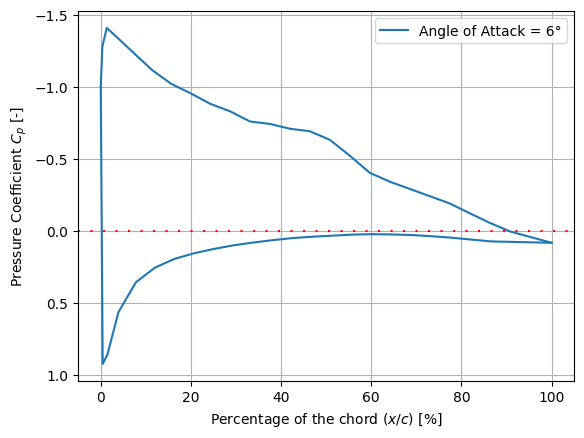

In [40]:
# select your angle of attack!

aoa = 6 

if aoa in pressures['Alpha'].values:
    temp = cp_distributions[cp_distributions['Alpha'] == aoa].copy(deep=True).reset_index()
else: 
    raise Exception('This angle of attack was not measured during the test or the number is inserted incorrectly')

colors = ['tab:blue', 'tab:orange']

for i in range(len(temp)):
    upper = temp.loc[i, 'P001':'P025'].to_numpy().flatten()
    lower = temp.loc[i, 'P026':'P049'].to_numpy().flatten()

    plt.plot(airfoil_ports['x'][0:25], upper, color= colors[i], label=f'Angle of Attack = {aoa}°')
    plt.plot(airfoil_ports['x'][25:49], lower, color= colors[i])
    
plt.axhline(0.0, linestyle=(0, (1, 5)), color='red')
plt.grid()
plt.xlabel('Percentage of the chord $(x/c)$ [%]')
plt.ylabel(r'Pressure Coefficient $C_p$ [-]')
plt.gca().invert_yaxis()

plt.legend()
plt.show()

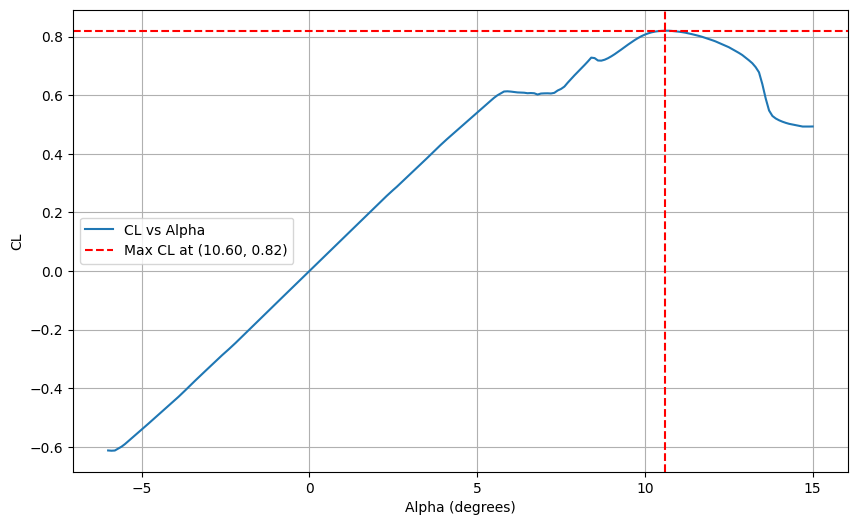

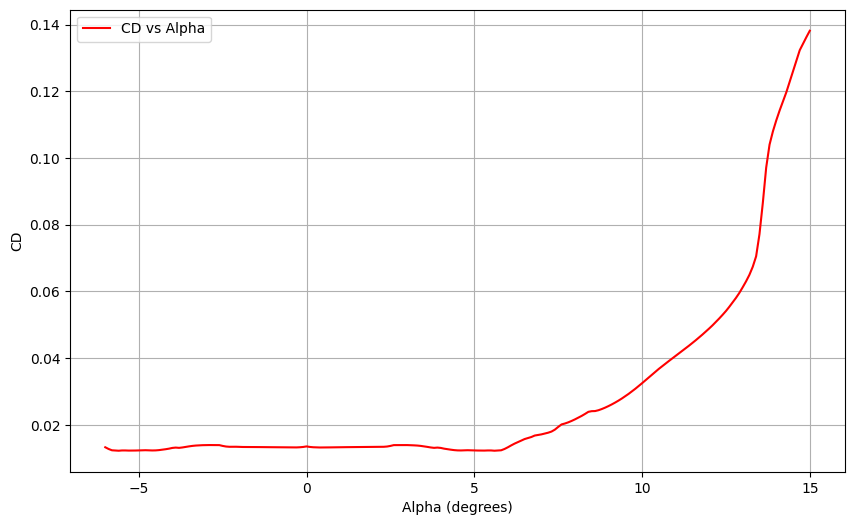

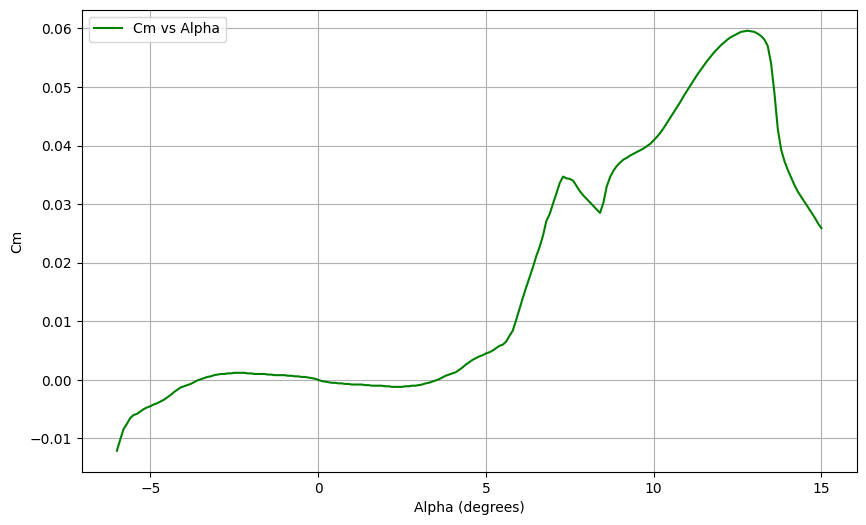

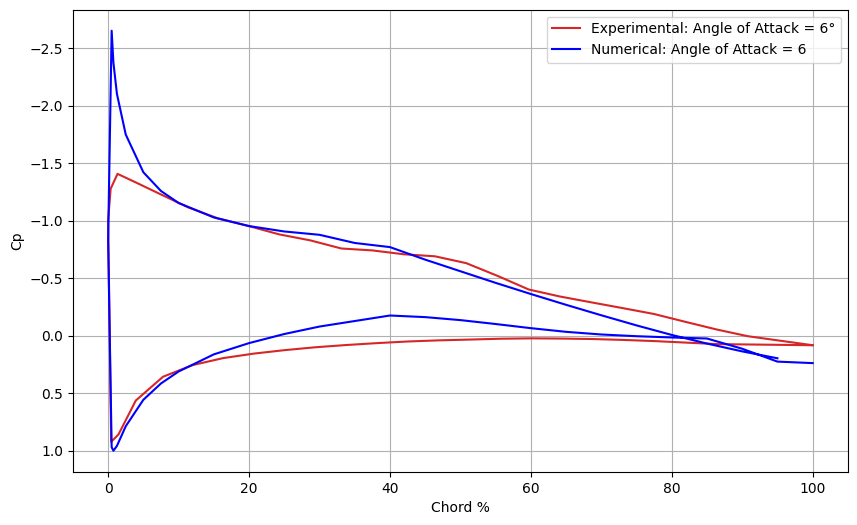

The maximum CL is 0.82 at alpha = 10.60 degrees.


In [41]:
# select your angle of attack!
aoa = 6 


# Load the data from the file, skipping the header lines
data = np.genfromtxt('NACA 642-015 AIRFOIL_T1_Re0.225_M0.06_N9.0.txt', skip_header=12)
Cp_data = np.genfromtxt('2D_XFLR_Cp_6deg.txt', skip_header=7)

# Extracting the columns for CL, CD, and Cm (columns 2, 3, and 5)
alpha = data[:, 0]  # Alpha (angle of attack) is the first column
CL = data[:, 1]     # CL is the second column
CD = data[:, 2]     # CD is the third column 
Cm = data[:, 4]     # Cm is the fifth column 

#% chord length
chord_fraction = Cp_data[:, 0] * 100  # Alpha (angle of attack) is the first column
cp = Cp_data[:, 2]  # Alpha (angle of attack) is the first column

# Filter the data for -6° <= alpha <= 15°
filtered_indices = (alpha >= -6) & (alpha <= 15)
alpha_filtered = alpha[filtered_indices]
CL_filtered = CL[filtered_indices]
CD_filtered = CD[filtered_indices]
Cm_filtered = Cm[filtered_indices]

# Find the maximum of the lift curve (CL)
max_CL_index = np.argmax(CL_filtered)
max_CL = CL_filtered[max_CL_index]
max_alpha = alpha_filtered[max_CL_index]

#Cl
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, CL_filtered, label='CL vs Alpha')
plt.axvline(x=max_alpha, linestyle='--', color='red', label=f'Max CL at ({max_alpha:.2f}, {max_CL:.2f})')
plt.axhline(y=max_CL, linestyle='--', color='red')
plt.xlabel('Alpha (degrees)')
plt.ylabel('CL')
plt.grid(True)
plt.legend()
#plt.savefig("Lift.svg", format="svg")
plt.show()

#Cd
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, CD_filtered, label='CD vs Alpha', color='r')
plt.xlabel('Alpha (degrees)')
plt.ylabel('CD')
plt.grid(True)
plt.legend()
#plt.savefig("Drag.svg", format="svg")
plt.show()

#Cm
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, Cm_filtered, label='Cm vs Alpha', color='g')
plt.xlabel('Alpha (degrees)')
plt.ylabel('Cm')
plt.grid(True)
plt.legend()
#plt.savefig("Moment.svg", format="svg")
plt.show()


if aoa in pressures['Alpha'].values:
    temp = cp_distributions[cp_distributions['Alpha'] == aoa].copy(deep=True).reset_index()
else: 
    raise Exception('This angle of attack was not measured during the test or the number is inserted incorrectly')

colors = ['tab:red', 'tab:orange']

#Cp
plt.figure(figsize=(10, 6))
for i in range(len(temp)):
    upper = temp.loc[i, 'P001':'P025'].to_numpy().flatten()
    lower = temp.loc[i, 'P026':'P049'].to_numpy().flatten()
    
    plt.plot(airfoil_ports['x'][0:25], upper, color= colors[i], label=f'Experimental: Angle of Attack = {aoa}°')
    plt.plot(airfoil_ports['x'][25:49], lower, color= colors[i])

plt.plot(chord_fraction, cp, label=f'Numerical: Angle of Attack = {aoa}', color='b')
plt.xlabel('Chord %')
plt.ylabel('Cp')
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()
#plt.savefig("Cp.svg", format="svg")
plt.show()


print(f"The maximum CL is {max_CL:.2f} at alpha = {max_alpha:.2f} degrees.")
